(sec:exercise-sudoku)=
# 演習1 - 画像入力式数独ソルバーを作る

ご存知の通り、数独というのは9x9のマスの中に1-9の数字を一定のルールのもとで入れていくパズルである。このルールとはすなわち、
- 同じ行に同じ数字が存在しない
- 同じ列に同じ数字が存在しない
- 3x3の9領域に同じ数字が存在しない

の3つである。数独の解き方にはいろいろなやり方があり、

- バックトラック法
- 整数計画問題として解く
- Exact Cover問題として解く

等のやり方がある。9x9の問題であれば、最も単純なバックトラック法でも十分高速に解くことができる(一般的なパズル本の最難問ならPython実装でも1秒以下で解ける)。

以下では、数独の問題を写真で撮って、その画像の中から問題を抜き出し、自動的に問題を解くプログラムを作成してみよう。

```{warning}
「数独」という呼び名はパズル製作会社のニコリによって商標登録されている呼び名であり、別の呼び名として「ナンバープレイス」あるいは「ナンプレ」と呼ばれることもある。本資料では、一般的に最も浸透していると思われる呼び名である「数独」を用いる。
```

## 数独を解く

まずは数独の問題がテキストで与えられている場合について、解き方を見ていこう。

今回は数独の問題が以下の形式のテキストとして与えられることとする。Pythonは複数行のテキストを以下のように定義することができる。

In [1]:
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

これを扱いやすくするためにNumPyの配列に直してみる。まずはテキストを行ごとの配列に変換する。各行は一般には改行文字である `\n`で区切られているが、実行する環境によっては、Windowsで`\r\n`、Macで`\r`など使われている文字が異なる可能性がある。

そこで、以下では、正規表現を用いて、`\n`あるいは`\r`が1個あるいは2個並んでいる場所で改行することにする。

In [2]:
import re

problem = re.split(r"[\r\n]{1,2}", problem)

ただし、このやり方だと空行が入る可能性があるので、以下のリスト内包表記を用いて取り除く。

In [3]:
problem = [line for line in problem if line != ""]
print(problem)

['-35-9--48', '--9--8--3', '-4-6-5--1', '----74---', '-2-----6-', '---15----', '8--9-2-7-', '9--5--2--', '61--4-53-']


するとproblemの長さは9となるはずだ。各行を文字ごとに分割するには、同じようにリスト内包表記を用いると簡単だ。以下は二重ループを用いたリスト内包表記の例だ。

In [4]:
problem = [c for line in problem for c in line]
print(problem)

['-', '3', '5', '-', '9', '-', '-', '4', '8', '-', '-', '9', '-', '-', '8', '-', '-', '3', '-', '4', '-', '6', '-', '5', '-', '-', '1', '-', '-', '-', '-', '7', '4', '-', '-', '-', '-', '2', '-', '-', '-', '-', '-', '6', '-', '-', '-', '-', '1', '5', '-', '-', '-', '-', '8', '-', '-', '9', '-', '2', '-', '7', '-', '9', '-', '-', '5', '-', '-', '2', '-', '-', '6', '1', '-', '-', '4', '-', '5', '3', '-']


すると今度はproblemが9x9=81個の要素を持つ一次元配列になる。現在、各数字は文字であり、数字ではないので、各文字を数字に置き換える。また、まだ埋まっていないセルを表す`-`は0に置き替える。以下のようにハッシュ(Pythonの用語ではdict)を使うと簡単に書ける。

In [5]:
numbers = {"-": 0}
numbers.update({str(i): i for i in range(1, 10)})
print(numbers)

{'-': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


あとはこれを使って文字を数字に置き換える。ここでもリスト内包表記を用いて処理をして、その後、NumPyの配列に直しておく。ここまで一次元配列で作業をしてきたが、9x9の二次元配列の方が以後の作業がやりやすいので、配列の形も直しておく。

In [6]:
import numpy as np

problem = np.array([numbers[c] for c in problem], dtype="uint8")
problem = problem.reshape((9, 9))
print(problem)

[[0 3 5 0 9 0 0 4 8]
 [0 0 9 0 0 8 0 0 3]
 [0 4 0 6 0 5 0 0 1]
 [0 0 0 0 7 4 0 0 0]
 [0 2 0 0 0 0 0 6 0]
 [0 0 0 1 5 0 0 0 0]
 [8 0 0 9 0 2 0 7 0]
 [9 0 0 5 0 0 2 0 0]
 [6 1 0 0 4 0 5 3 0]]


とすると、先ほどまでの文字が数字に置き換わるはずだ。なお、ここまで繰り返しリスト内包表記も用いたが、これらをまとめて1行で書くこともできる。

In [7]:
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

In [8]:
problem = np.array(
    [numbers[c] for line in re.split("[\r\n]{1,2}", problem) if line != "" for c in line],
    dtype="uint8",
).reshape((9, 9))
print(problem)

[[0 3 5 0 9 0 0 4 8]
 [0 0 9 0 0 8 0 0 3]
 [0 4 0 6 0 5 0 0 1]
 [0 0 0 0 7 4 0 0 0]
 [0 2 0 0 0 0 0 6 0]
 [0 0 0 1 5 0 0 0 0]
 [8 0 0 9 0 2 0 7 0]
 [9 0 0 5 0 0 2 0 0]
 [6 1 0 0 4 0 5 3 0]]


```{admonition} 改行文字
:class: note

改行文字はOSによってデフォルトで使われているものが異なり、Windowsは`\r\n`、Macは`\r`、Linuxは`\n`が用いられている。これらの改行文字は`\r`がcarriage return (CR)と呼ばれ、`\n`がline feed (LF)と呼ばれることから、Windows、Mac、Linuxで用いられる改行をそれぞれCRLF、CR、LF改行とも呼ぶ。

プログラミングにおいては、改行文字の違いが問題となることも多いので、LFに統一する、あるいはCRLFに統一する、など自分でルールを決めてエディタ(VSCodeなど)を設定しておくと良い。
```

### 使用済みの数字を調べる

問題が数字の配列として表せたところで、使用済みの数字を調べる方法を見ていく。今`i`行`j`列にある数字の候補にどの数字が残っているのかを調べたいとする。

NumPyを用いると、`i`行目にある数字は`problem[i, :]`という配列で、`j`列目にある数字は`problem[:, j]`という配列で表せる。また3x3のブロックについては、ブロックの右上の座標が`(3 * (i // 3), 3 * (j // 3))`と表せることに注目すれば、以下でブロック内の数字が得られる。

```python
k = 3 * (i // 3)
l = 3 * (j // 3)
blk_nums = problem[k:k+3, l:l+3.flatten()  # 一次元配列として取り出す
```

一例として1行1列の空マスに何が入るのかを調べて見る。行、列、ブロックに使われている数字は、それぞれ以下のようになっている。

In [9]:
row_nums = problem[0, :]
print("    Row #1:", row_nums)
col_nums = problem[:, 0]
print("    Col #1:", col_nums)
blk_nums = problem[0:3, 0:3].flatten()
print("Block #1-1:", blk_nums)

    Row #1: [0 3 5 0 9 0 0 4 8]
    Col #1: [0 0 0 0 0 0 8 9 6]
Block #1-1: [0 3 5 0 0 9 0 4 0]


まだ使える数字は1-9の数字の中で、これらの配列に現れていない数字である。配列中に数字があるかどうかは`in`を使うと調べられるので、リスト内包表記を使えば、未使用の数字が簡単に調べられる。

In [10]:
used_nums = np.concatenate([row_nums, col_nums, blk_nums])
unused_nums = np.array([i for i in range(10) if not i in used_nums], dtype="uint8")
print("Unused numbers:", unused_nums)

Unused numbers: [1 2 7]


このように、`(0, 0)`の空マスに入りうる候補の数字は`{1, 2, 7}`の3つであることが分かる。

### バックトラック法による解法

最初に、数独をコンピュータに解かせる最も単純な方法を考えてみよう。

上記の使用済みの数字を調べる方法を少し変更すれば、各行、各列、各ブロックで数字が正しく1度だけ使われているかどうかを調べることができそうだ。とすれば、全ての空きマスに適当に数字を入れて、その結果が正しいかどうかを順に試せば良さそうに思える。

ただ、これでは正しい解が見つかる確率が低すぎるため、計算に時間がかかりすぎる。各マスに入れられる数字の候補は9通りでマスが81マスあるので、最悪の場合には$9^{81} \approx 2.0 \times 10^{77}$個の候補について調べる必要がある。

一方で、実際にはいくつかのマスにはすでに数字が入っており、上記のように何も考えずに全てのパターンを試すのは非常に効率が悪いことが分かる。そこで、可能な候補についてだけ、しらみ潰しに調べることを考える。これを実現するのがバックトラック法である。

これでも効率がとても良いとは言えないが、実際には最初の方の数字がある程度決まると、後の方の数字は急速に候補が少なくなるため、実用的にはそれなりに高速に動作する。少なくとも9x9の問題であれば、十分に速い(16x16の問題になるとそうはいかない！)

バックトラック法は**深さ優先探索**の一種で、数独の例で言えば、**候補となる数字を仮に入れる操作をできる限り繰り返し、もし最後のマスまで数字が入れば成功、途中で数字が入れられなくなったら失敗**として違う候補を試す、というものである。

深さ優先探索の実装方法は**再帰関数を使う方法**とFILO (first in last out, 最初に入れたものが最後に取り出されるということ) **データ構造 (一般にはスタックと呼ぶ) を用いる方法**の2つがある。

どちらの方法にも一長一短があるが、今回はスタックを用いる方法で実装を進める。

バックトラック法による数独の解法の流れは次のようになる。

1. **初期化:** スタックに入力の問題を追加
2. **深さ優先探索:**
    1. スタックに積まれた問題の途中経過を取り出す
    2. マスの中で、まだ空マスになっている最初のマスの候補を割り出す
    3. その空マスに各候補を入れたものをスタックに追加
    4. この際、もしマスが全て埋まっていたら、成功と見なし処理を終了 

この部分の実装は演習課題とするが、上手く問題が解ければ、以下のような解答が得られるはずである。

In [11]:
from itertools import product


def solve(problem):
    stk = []
    stk.append(problem.copy())
    solution = None

    while len(stk) != 0:
        P = stk.pop()
        success = True
        for i, j in product(range(P.shape[0]), range(P.shape[1])):
            if P[i, j] == 0:
                success = False
                row_nums = P[i, :]
                col_nums = P[:, j]
                k = 3 * (i // 3)
                l = 3 * (j // 3)
                blk_nums = P[k : k + 3, l : l + 3].flatten()

                used_nums = np.concatenate([row_nums, col_nums, blk_nums])
                unused_nums = [n for n in range(10) if not n in used_nums]
                for n in unused_nums:
                    new_P = P.copy()
                    new_P[i, j] = n
                    stk.append(new_P)

                # if the first empty cell is found, then,
                # we don't need to see the following cells anymore.
                break

        if success:
            solution = P.copy()
            break

    return solution

In [12]:
import matplotlib.pyplot as plt


def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []

    ax.set_title("Sudoku solving animation")
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        if z != 0:
            txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
            frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

    return frame

In [13]:
from IPython import display
from matplotlib.animation import ArtistAnimation

fig = plt.figure()
ax = fig.gca()
frames = []

stk = []
stk.append(problem.copy())
solution = None

while len(stk) != 0:
    P = stk.pop()
    frame = draw_frame(P, fig, ax)
    frames.append(frame)
    success = True
    for i, j in product(range(P.shape[0]), range(P.shape[1])):
        if P[i, j] == 0:
            success = False
            row_nums = P[i, :]
            col_nums = P[:, j]
            k = 3 * (i // 3)
            l = 3 * (j // 3)
            blk_nums = P[k : k + 3, l : l + 3].flatten()

            used_nums = np.concatenate([row_nums, col_nums, blk_nums])
            unused_nums = [n for n in range(10) if not n in used_nums]
            for n in unused_nums:
                new_P = P.copy()
                new_P[i, j] = n
                stk.append(new_P)

            # if the first empty cell is found, then,
            # we don't need to see the following cells anymore.
            break

    if success:
        solution = P.copy()
        break

ani = ArtistAnimation(fig, frames, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)
plt.close()

In [14]:
print("Solution is:\n" + str(solve(problem)))

Solution is:
[[2 3 5 7 9 1 6 4 8]
 [1 6 9 4 2 8 7 5 3]
 [7 4 8 6 3 5 9 2 1]
 [3 9 6 2 7 4 8 1 5]
 [5 2 1 3 8 9 4 6 7]
 [4 8 7 1 5 6 3 9 2]
 [8 5 3 9 6 2 1 7 4]
 [9 7 4 5 1 3 2 8 6]
 [6 1 2 8 4 7 5 3 9]]


In [15]:
%%capture perf
%%timeit -n 1 -r 10
solve(problem)

In [16]:
print("Execution time:\n" + str(perf))

Execution time:
23.1 ms +- 1.61 ms per loop (mean +- std. dev. of 10 runs, 1 loop each)



In [17]:
from IPython.display import Markdown

avg_time = " ".join(perf.stdout.split(" ")[0:2])

Markdown(f"上記は、素直にバックトラック法を実装した場合の実行時間であるが、一回の問題を解くのに平均{avg_time:s}となっており、十分高速であることが分かる")

上記は、素直にバックトラック法を実装した場合の実行時間であるが、一回の問題を解くのに平均23.1 msとなっており、十分高速であることが分かる

### 処理の効率化

上記の方法でも、最初に示した数独の問題であれば数十ミリ秒で解くことができる。だが、次の問題はどうだろう？

参照: <https://www.j-cast.com/premium/2018/10/19341452.html?p=all>

In [18]:
problem = """
---------
3--2-9--7
94--1--82
-5-6-2-3-
--63-74--
---------
---------
-82-3-59-
1--9-4--6
"""

In [19]:
problem = np.array(
    [numbers[c] for line in re.split("[\r\n]{1,2}", problem) if line != "" for c in line],
    dtype="uint8",
).reshape((9, 9))

In [20]:
print("Solution is:\n" + str(solve(problem)))

Solution is:
[[5 2 1 7 6 8 3 4 9]
 [3 6 8 2 4 9 1 5 7]
 [9 4 7 5 1 3 6 8 2]
 [4 5 9 6 8 2 7 3 1]
 [8 1 6 3 9 7 4 2 5]
 [2 7 3 4 5 1 9 6 8]
 [6 9 4 8 7 5 2 1 3]
 [7 8 2 1 3 6 5 9 4]
 [1 3 5 9 2 4 8 7 6]]


In [21]:
%%capture perf
%%timeit -n 1 -r 10
solve(problem)

In [22]:
print("Execution time:\n" + str(perf))

Execution time:
1.48 s +- 30.4 ms per loop (mean +- std. dev. of 10 runs, 1 loop each)



この問題だと、上記の通り1秒以上は時間がかかるはずだ。

実は、上記のコードは次の0のマスを探すまでの処理の効率が非常に悪い。0のマスは左上から右下に向かって探しているのだから、今新しく`(i, j)`というマスに数字を入れたら`(i, j+1)`以降の数字だけを調べれば良いのである。

その他にも、バックトラック法を高速化するために、候補の数が少ないものから埋めていくなどの方法も考えられる。ぜひ、自分でプログラムを書いて試してみてほしい。確認用に難易度の異なる4問を示しておく。

In [23]:
# レベル1
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

In [24]:
# レベル2
# https://si-coding.net/sudoku10.html
problem = """
------1-4
4---78---
-3------2
5--4-7-3-
2------5-
9---264--
-27------
--56----7
-6--13---
"""

In [25]:
# レベル3
# https://www.j-cast.com/premium/2018/10/19341452.html?p=all
problem = """
---------
3--2-9--7
94--1--82
-5-6-2-3-
--63-74--
---------
---------
-82-3-59-
1--9-4--6
"""

In [26]:
# 世界一難しい？
# https://www.conceptispuzzles.com/ja/index.aspx?uri=info/article/424
problem = """
8--------
--36-----
-7--9-2--
-5---7---
----457--
---1---3-
--1----68
--85---1-
-9----4--
"""

### 発展: Exact Coverによる高速な解法

バックトラック法よりも遙かに高速な解法として、数独の問題をExact Coverの問題として定式化する方法がある。

Exact Cover問題とは、とある集合$\mathcal{S}$と、その部分集合$s_1, \ldots, s_n$がいくつか与えられた時に、以下の2つの条件を満たすように部分集合を選ぶ問題である。

**条件1:** 選ばれた部分集合$s_{i_1}, \ldots, s_{i_M}$の和集合が集合$\mathcal{S}$と同じになる
- $\mathcal{S} = \bigcap_{m=1}^M s_{i_m}$

**条件2:** 選ばれた部分集合$s_{i_1}, \ldots, s_{i_M}$から任意の2つを選び出したとき、それらの積集合が空
- $s_{i_n} \cup s_{i_m} = \phi, \quad \forall n \neq m$

```{admonition} Exact Coverの例
:class: note

一例として$\mathcal{S} = \{1, 2, 3, 4, 5\}$を考える。このとき、

- $s_1 = \{1, 2\}$
- $s_2 = \{2, 3\}$
- $s_3 = \{4, 5\}$
- $s_4 = \{ 3 \}$
- $s_5 = \{1, 3, 5\}$

であるなら、$s_1, s_3, s_4$の組み合わせは$\mathcal{S}$のExact Coverである。
```

---

Exact Coverにはいくつかの解法があり、Donald Knuthが提案したAlgorithm Xと呼ばれる解法が広く知られている。この解法には、通常、Dancing Linksという、二次元配列を上下左右に双方向連結リストで表現したようなデータ形式を用いる。Dancing Linksには、配列の行や列の消去が効率的に行えるが、やや実装の難易度が高い。

今回はDancing Linksの代わりにPandasの`DataFrame`を用いて、Exact CoverをAlgorithm Xによって解いてみる。まずは、単純な例として、上記の「Exact Coverの例」について、Algorithm Xでの解法を見てみる。

このデータを表で表わすと以下のようになる。

In [27]:
import numpy as np
import pandas as pd
from IPython import display

# DataFrameを作成し、データを0で初期化
df = pd.DataFrame(index=["s_1", "s_2", "s_3", "s_4", "s_5"], columns=[1, 2, 3, 4, 5])
df.iloc[:] = 0

# 部分集合の情報を入力
df.loc["s_1", [1, 2]] = 1
df.loc["s_2", [2, 3]] = 1
df.loc["s_3", [4, 5]] = 1
df.loc["s_4", [3]] = 1
df.loc["s_5", [1, 3, 5]] = 1

# 表の表示
display.display(df)

,1,2,3,4,5
s_1,1,1,0,0,0
s_2,0,1,1,0,0
s_3,0,0,0,1,1
s_4,0,0,1,0,0
s_5,1,0,1,0,1


この表では、各部分集合について、値を持っている部分に1が、持っていない部分に0が入っている。Exact Coverが解くべき問題を表を用いて言い換えれば、「表の行のうちのいくつかを取り出して表を作ったときに、各列に必ず1つだけ1が存在する」ようにすること、となる。

これを実現するために、Algorithm Xでは、各列を見たときに、最も1が少ない列に注目する。この表では、「4」の列が最も1の数が少ない列である。なお、この操作の時に最も1が少ない列がもつ1の数が0である (つまる列の要素が全て0の列が存在する)場合には、Exact Coverは不可能なので処理を終了する。

In [28]:
def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if columns[j] == 4:
                s.append("background-color: pink; font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.apply(custom_style, axis=None)

,1,2,3,4,5
s_1,1,1,0,0,0
s_2,0,1,1,0,0
s_3,0,0,0,1,1
s_4,0,0,1,0,0
s_5,1,0,1,0,1


このとき、仮に複数の列が同じ数の1を持っていたとしても、その操作のうち任意の一つだけを選択すれば良く、**それらを順々に処理する必要はない**。なぜなら、仮にここでその列を選択しなかったとしても、以後の処理でExact Coverを実現するために、**いずれ残りの列も選択される**ためだ。

今回は、1の数が一つだけの列は4列目だけなので、これを選んで処理を進める。選ばれた列に対して、値が1となっている「行」を順々に見ていく。今回は**s_3**の行だけが1を持っているので、この行を選択する。

In [29]:
def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if index[i] == "s_3" and columns[j] == 4:
                s.append("background-color: plum; font-weight: bold;")
            elif index[i] == "s_3":
                s.append("background-color: powderblue; font-weight: bold;")
            elif columns[j] == 4:
                s.append("background-color: pink; font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.apply(custom_style, axis=None)

,1,2,3,4,5
s_1,1,1,0,0,0
s_2,0,1,1,0,0
s_3,0,0,0,1,1
s_4,0,0,1,0,0
s_5,1,0,1,0,1


選択された行の要素のうち、1を持っている「列」に次は注目する。今回の例では、4, 5行目が1の値を持っている。これらの列で、1の要素を持っている「行」を洗い出す。すると、**s_3**, **s_5**の行が1の要素を4, 5列目の少なくともいずれかに1の値を持っている。

今、**s_3**の行を選択したということは、それが満たす条件である**4**, **5**の列は不要であり、また同じ条件を満たす**s_5**はExact Coverを達成する上で選ばれてはいけないから、これらの行、列を削除して良いことが分かる。

In [30]:
def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if index[i] in ["s_3", "s_5"] and columns[j] in [4, 5]:
                s.append("background-color: plum; font-weight: bold;")
            elif index[i] in ["s_3", "s_5"]:
                s.append("background-color: powderblue; font-weight: bold;")
            elif columns[j] in [4, 5]:
                s.append("background-color: pink; font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.apply(custom_style, axis=None)

,1,2,3,4,5
s_1,1,1,0,0,0
s_2,0,1,1,0,0
s_3,0,0,0,1,1
s_4,0,0,1,0,0
s_5,1,0,1,0,1


ここまでの処理をまとめると、以下の手順になる。

1. 各**列**が持つ1の数を数えて、最も少ない1を持つ列の中の1つ(**列X**とする)を選ぶ
1. 列Xの要素の中で1を持つ行を1つ(**行A**とする)を選ぶ
1. 行Aの中で1の要素を持つ列 (**列x, 列y, ...** とする)を選ぶ
1. 列x, 列y, ...の各列において、少なくとも一つの1を持つ行 (**行a, 行b, ...** とする)を選ぶ

選ばれた **列x, 列y, ...** ならびに **行a, 行b, ...** を元の表から削除すると、小さな表が得られる。上記の例を用いると、色がついていないセルだけが残り、以下のような表が得られる。

In [31]:
new_df = df.loc[["s_1", "s_2", "s_4"], [1, 2, 3]]
new_df

,1,2,3
s_1,1,1,0
s_2,0,1,1
s_4,0,0,1


このようにして、小さな表が得られたら、上記の手順1-4をこの表に対しても繰り返す。この表は、1列目が、最も少ない1を持つので、選ばれる **列x, 列y, ...** ならびに **行a, 行b, ...** に色をつけると以下のようになる。

In [32]:
def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if index[i] in ["s_1", "s_2"] and columns[j] in [1, 2]:
                s.append("background-color: plum; font-weight: bold;")
            elif index[i] in ["s_1", "s_2"]:
                s.append("background-color: powderblue; font-weight: bold;")
            elif columns[j] in [1, 2]:
                s.append("background-color: pink; font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


new_df.style.apply(custom_style, axis=None)

,1,2,3
s_1,1,1,0
s_2,0,1,1
s_4,0,0,1


ここで、再度選ばれた行、列を削除すると、次は、以下のような表が得られる。

In [33]:
new_df2 = new_df.loc[["s_4"], [3]]
new_df2

,3
s_4,1


このように表に対して、再度上記の操作を繰り返すと、**表全体が選択されて、空の表になる**ことが分かる (このとき、表の値が全て1であるとは限らないが、少なくとも1行は全ての列が1となる行が存在する)。このような空の表が現れたら処理を終了し、これまでに選択した列のインデックスの列を返すと、Exact Coverとなる部分集合の列が得られる。

ここまでの処理で、手順2で選ばれた行を列挙すると、最初に**s_3**が、次に**s_1**が、そして最後に**s_4**が選ばれた。この三つの部分集合は元の集合$\mathcal{S}$のExact Coverとなっており、Algorithm Xにより問題が正しく解けていることが確認できた。

なお、Pandasの`DataFrame`を用いた実装は以下のようになる。

In [34]:
# Knuth's Algorithm X
def dfs(df: pd.DataFrame):
    # 使い勝手のためにNumPy配列に変換
    m = df.to_numpy()
    if m.size == 0:
        return []

    # 1の数が最小の行を探す
    sums = np.sum(m, axis=0)
    sc = np.argmin(sums)
    if sums[sc] == 0:
        return None

    sel_rows = np.where(m[:, sc])[0]
    for sr in sel_rows:
        mask_cols = np.where(m[sr, :])[0]
        mask_rows = [np.where(m[:, c])[0] for c in mask_cols]
        mask_rows = np.unique(np.concatenate(mask_rows))

        new_df = df.drop(index=df.index[mask_rows]).drop(columns=df.columns[mask_cols])
        ret = dfs(new_df)
        if ret is not None:
            return ret + [df.index[sr]]

    return None

In [35]:
solution = dfs(df)
if solution is not None:
    print("The solution for exact cover is:", sorted(solution))
else:
    print("Solution not found!")

The solution for exact cover is: ['s_1', 's_3', 's_4']


---

**数独のExact Coverによる定式化**

では、数独の問題をExact Coverの問題として定式化してみよう。これには、数独の問題を少し違った見方から捕らえる必要がある。

まず、各セルに何らかの値が入った場合に何が起こるのかを考えてみる。とあるA行X列のセルAXに1が入ることは、

- セルAXには1-9のうち1が入るという**操作**がなされた
- セルAXに数字が入るという**条件**が満たされた
- A行目に1が入るという**条件**が満たされた
- X列目に1が入るという**条件**が満たされた
- セルAXが属するブロックに1が入るという**条件**が満たされた

という操作とそれによって充足される条件を意味する。これを集合の表記で書くとすれば、

$$
s_{\text{Row-A,Col-X}} = \{ c_{\text{Fill,Row-A,Col-X}}, c_{\text{1,Row-A}}, c_{\text{1, Col-X}} c_{\text{1, Blk-N}} \}
$$

のようになり、$c_{\text{Fill,Row-A,Col-X}}$はA行X列に数字が入ることを、$c_{\text{1,Row-A}}$は行Aに1が入ることを、$ c_{\text{1, Col-X}}$はX列に1が入ることを、$c_{\text{1, Blk-N}}$はブロックNに1が入ることをそれぞれ表わす。

このように数独の問題を捕らえ直すと、セルに数字を入れるという操作は、とある条件の全体集合の部分集合になっていることが分かる。

この際、操作の数は数字を入れるセルが9×9=81個あり、そこに1-9の9種類の数字が入りうるので、**729個の操作があり得る**ことが分かる。

また、満たすべき条件としては、9×9個のセルに数字が入る (81通り)、9個の各行に1-9の数字が入る (9×9=81通り)、9個の各列に1-9の数字が入る (9x9=81通り)、9個のブロックに1-9の数字が入る(9×9=81通り)の合計**324通りの条件がある**ことが分かる。

さらに、各条件は1つの操作によってしか満たされない (例: とある列に二つの2が入ることはあり得ない)ので、数独の問題が、729個ある操作からいくつか (実際には81個)を選んで、324個の条件をちょうど1度ずつ満たす問題、すなわち、Exact Coverの問題であることが分かる。

以上の議論より、数独をExact Coverの問題として解くには729×324の大きさの表を作り、数字が既知のセルに対応する条件に1を入れる。この表に対してAlgorithm Xを適用すれば、必要な操作(=どのセルにどの数字を入れるか)を決定することができる。

以下では、各セルに数字を入れる操作を**R1C1#1**のように表わすこととし、セルに数字が入るという条件を**R1C1**、行に数字が入るという条件を**R1#1**、列に数字が入るという条件を**C1#1**、ブロックに数字が入るという操作を**B1#1**のように表わすことにする。

このルールに従うと、Algorithm Xで処理すべきPandasの`DataFrame`は以下のように作成できる。

In [36]:
index = [
    "R{:d}C{:d}#{:d}".format(i, j, n)
    for i in range(1, 10)
    for j in range(1, 10)
    for n in range(1, 10)
]
cond1 = ["R{:d}C{:d}".format(i, j) for i in range(1, 10) for j in range(1, 10)]
cond2 = ["R{:d}#{:d}".format(i, n) for i in range(1, 10) for n in range(1, 10)]
cond3 = ["C{:d}#{:d}".format(j, n) for j in range(1, 10) for n in range(1, 10)]
cond4 = ["B{:d}#{:d}".format(b, n) for b in range(1, 10) for n in range(1, 10)]
conds = cond1 + cond2 + cond3 + cond4

df = pd.DataFrame(index=index, columns=conds, dtype="bool")
df.iloc[:] = 0
display.display(df)

,R1C1,R1C2,R1C3,R1C4,R1C5,R1C6,R1C7,R1C8,R1C9,R2C1,...,B8#9,B9#1,B9#2,B9#3,B9#4,B9#5,B9#6,B9#7,B9#8,B9#9
R1C1#1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R9C9#5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R9C9#6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R9C9#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R9C9#8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


この表に対して、数独の問題が全て空マスの場合の条件を代入していく。

In [37]:
for i in range(9):
    for j in range(9):
        for n in range(1, 10):
            r = i + 1
            c = j + 1
            b = (i // 3) * 3 + (j // 3) + 1
            op = "R{:d}C{:d}#{:d}".format(r, c, n)
            cd1 = "R{:d}C{:d}".format(r, c)
            cd2 = "R{:d}#{:d}".format(r, n)
            cd3 = "C{:d}#{:d}".format(c, n)
            cd4 = "B{:d}#{:d}".format(b, n)
            df.loc[op, [cd1, cd2, cd3, cd4]] = 1

display.display(df)

,R1C1,R1C2,R1C3,R1C4,R1C5,R1C6,R1C7,R1C8,R1C9,R2C1,...,B8#9,B9#1,B9#2,B9#3,B9#4,B9#5,B9#6,B9#7,B9#8,B9#9
R1C1#1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R9C9#5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
R9C9#6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
R9C9#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
R9C9#8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


続いては、問題に既に入っている数字を元に表の操作と条件を書き換える。一例として、1行2列に3という数字が入っていたとする。この場合、1行2列に3以外の数字が入る、という条件、即ち**R1C2#1**や**R1C2#8**などは起こりえないので、これらを表の行から除去して良い。

また、1行2列に3が入るということは、他の操作により1行目に3が入ったり、2列目に3が入ったりすることはない、ということを意味する。従って、同様の条件を満たす可能性のある操作、即ち**R1C5#3**や**R4C2#3**なども表から消去して良いことが分かる。

今回は、先ほど1秒以上時間のかかった問題を例に、ルールに従って表を変形してみる。

In [38]:
problem = """
---------
3--2-9--7
94--1--82
-5-6-2-3-
--63-74--
---------
---------
-82-3-59-
1--9-4--6
"""

problem = np.array(
    [numbers[c] for line in re.split(r"[\r\n]{1,2}", problem) if line != "" for c in line],
    dtype="uint8",
).reshape((9, 9))

print(problem)

[[0 0 0 0 0 0 0 0 0]
 [3 0 0 2 0 9 0 0 7]
 [9 4 0 0 1 0 0 8 2]
 [0 5 0 6 0 2 0 3 0]
 [0 0 6 3 0 7 4 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 8 2 0 3 0 5 9 0]
 [1 0 0 9 0 4 0 0 6]]


In [39]:
for i in range(9):
    for j in range(9):
        if problem[i, j] != 0:
            r = i + 1
            c = j + 1
            b = (i // 3) * 3 + (j // 3) + 1
            n = problem[i, j]
            del_op1 = ["R{:d}C{:d}#{:d}".format(r, c, n_) for n_ in range(1, 10) if n != n_]
            del_op2 = ["R{:d}C{:d}#{:d}".format(r_, c, n) for r_ in range(1, 10) if r != r_]
            del_op3 = ["R{:d}C{:d}#{:d}".format(r, c_, n) for c_ in range(1, 10) if c != c_]
            del_op4 = [
                "R{:d}C{:d}#{:d}".format(r_, c_, n)
                for r_ in range(i // 3 * 3 + 1, i // 3 * 3 + 4)
                for c_ in range(j // 3 * 3 + 1, j // 3 * 3 + 4)
                if r != r_ or c != c_
            ]

            del_op = list(set(del_op1 + del_op2 + del_op3 + del_op4))
            df.drop(index=[id for id in del_op if id in df.index], inplace=True)

display.display(df)

,R1C1,R1C2,R1C3,R1C4,R1C5,R1C6,R1C7,R1C8,R1C9,R2C1,...,B8#9,B9#1,B9#2,B9#3,B9#4,B9#5,B9#6,B9#7,B9#8,B9#9
R1C1#2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R1C1#8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R9C7#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
R9C7#8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
R9C8#2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
R9C8#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


この表を元にExact Cover問題の解法をDancing Links(と類似したデータ構造)を用いて実装すると、正しい答えが、バックトラック法よりも数段高速に求まる。以下、ソースコードは示さないが、実行結果と、その際の実行時間を示す。プログラミングに自信のある読者は、ぜひ前述の`DataFrame`を使った例を参考に、より高速な実装に取り組んでほしい。

In [40]:
from typing import Any, Set, Dict, List

ops = {op: set() for op in df.index}
cds = {cd: set() for cd in df.columns}


for op in ops.keys():
    cds_for_op = df.columns[df.loc[op, :] == 1]
    ops[op].update(cds_for_op)

for cd in cds.keys():
    ops_for_cd = df.index[df.loc[:, cd] == 1]
    cds[cd].update(ops_for_cd)


def exact_cover(rows: Dict[str, Set[str]], cols: Dict[str, Set[str]]) -> List[str]:
    sc = min(cols, key=lambda k: len(cols[k]))
    if cols[sc] == 0:
        return []

    sel_rows = list(cols[sc])
    for sr in sel_rows:
        mask_cols = rows[sr]
        mask_rows = set().union(*(cols[mc] for mc in mask_cols))

        # mask rows/cols
        for i in mask_rows:
            for j in rows[i]:
                cols[j].discard(i)

        masked_rows = {k: rows.pop(k) for k in mask_rows}
        masked_cols = {k: cols.pop(k) for k in mask_cols}

        if len(cols) == 0:
            return [sr]

        # depth-first search
        ret = exact_cover(rows, cols)
        if len(ret) > 0:
            return ret + [sr]

        # unmask rows/cols
        rows.update(masked_rows)
        cols.update(masked_cols)

        for i in mask_rows:
            for j in rows[i]:
                cols[j].add(i)

    return []

In [41]:
from copy import deepcopy

rows = deepcopy(ops)
cols = deepcopy(cds)
solution = exact_cover(rows, cols)

In [42]:
answer = np.zeros((9, 9), dtype="int32")
for s in solution:
    pat = re.compile(r"R([1-9]{1})C([1-9]{1})#([1-9]{1})")
    mat = pat.search(s)
    r = int(mat.group(1))
    c = int(mat.group(2))
    n = int(mat.group(3))
    answer[r - 1, c - 1] = n

print(answer)

[[5 2 1 7 6 8 3 4 9]
 [3 6 8 2 4 9 1 5 7]
 [9 4 7 5 1 3 6 8 2]
 [4 5 9 6 8 2 7 3 1]
 [8 1 6 3 9 7 4 2 5]
 [2 7 3 4 5 1 9 6 8]
 [6 9 4 8 7 5 2 1 3]
 [7 8 2 1 3 6 5 9 4]
 [1 3 5 9 2 4 8 7 6]]


In [43]:
%%capture perf
%%timeit -n 1 -r 10
rows = deepcopy(ops)
cols = deepcopy(cds)
exact_cover(rows, cols)

In [44]:
print("Execution time:\n" + str(perf))

Execution time:
6.91 ms +- 217 us per loop (mean +- std. dev. of 10 runs, 1 loop each)



In [45]:
avg_time = " ".join(perf.stdout.split(" ")[0:2])

display.Markdown(
    f"すると先ほど1秒以上かかっていた問題が、**たったの{avg_time:s}で解けている**ことが分かる。このように、数独の問題をExact Coverの問題と捉えることが、通常のバックトラック法よりも遙かに高速に問題を解けることが確認できた。"
)

すると先ほど1秒以上かかっていた問題が、**たったの6.91 msで解けている**ことが分かる。このように、数独の問題をExact Coverの問題と捉えることが、通常のバックトラック法よりも遙かに高速に問題を解けることが確認できた。

```{admonition} なぜ速く解けるのか？
:class: note

今紹介したExact Coverを解くAlgorithm Xでは、表の列の中で**最も1の数が少ない列**を選んでいる。この操作が何を意味するかを考えてみよう。

表の列に1が入っている行というのは、その列に対応する操作を行うことで、列が表わす条件が満たされることを意味する。従って「最も1の数が少ない列」というのは「その列が表わす条件を満たすために選択しうる【セルへの数字の代入操作】の候補数が最も少ない」ということを意味する。

Algorithm Xは、ある意味では深さ優先探索を用いたバックトラック法の一種と考えることができるが、このように候補の数が最も少ない物から順に処理することで、深さが下がるごとに急速に表のサイズが小さくなるため、処理の効率が良い。これがExact Coverによる定式化をAlgorithm Xで解くと高速に動作する理由である。
```

## 演習: コンピュータ数独大会

ここまでの内容を利用して、写真から数独の問題を読み取り、答えを返すプログラムを作成してみよう。

本番では、以下のレベル1-3の内容で10問ずつ画像を与える。レベル1が1点、レベル2が2点、レベル3が3点の合計60点のうち何点を取れるかを競う。各レベルの画像は以下のような性質を持つ。

- **レベル1:** 問題が白い背景の上に写っている
- **レベル2:** 問題が平面の上に写っているが、問題が斜めから撮影されている
- **レベル3:** 問題が書籍のような湾曲した面に印刷されている

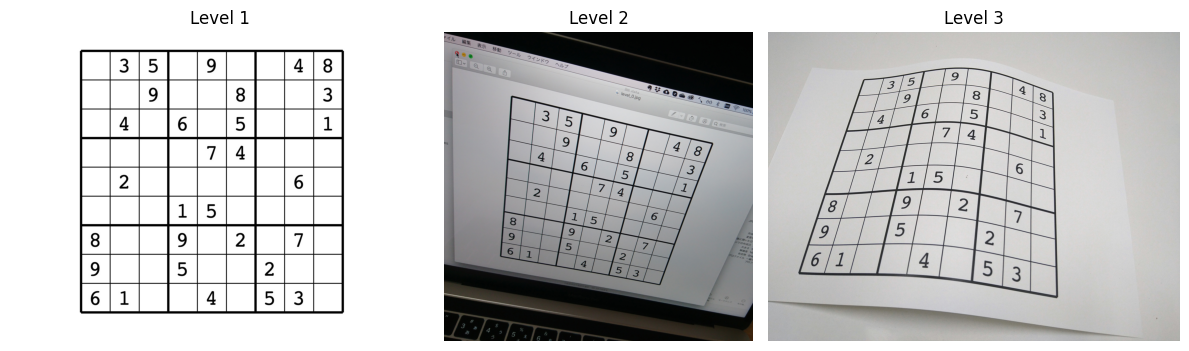

In [46]:
import cv2
import matplotlib.gridspec as gridspec

level1 = cv2.imread("../../data/sudoku/level_1.jpg")[:, :, ::-1]
level2 = cv2.imread("../../data/sudoku/level_2.jpg")[:, :, ::-1]
level3 = cv2.imread("../../data/sudoku/level_3.jpg")[:, :, ::-1]

fig = plt.figure(figsize=(12, 4))

a1 = level1.shape[1] / level1.shape[0]
a2 = level2.shape[1] / level2.shape[0]
a3 = level3.shape[1] / level3.shape[0]

# create subplots
gs = gridspec.GridSpec(1, 3, width_ratios=[a1, a2, a3])
p1 = plt.subplot(gs[0])
p2 = plt.subplot(gs[1])
p3 = plt.subplot(gs[2])

p1.imshow(level1, interpolation=None)
p1.axis("off")
p1.set_title("Level 1")

p2.imshow(level2, interpolation=None)
p2.axis("off")
p2.set_title("Level 2")

p3.imshow(level3, interpolation=None)
p3.axis("off")
p3.set_title("Level 3")

plt.tight_layout()
plt.show()

**入力の形式**

入力としては、NumPyの配列として`(H, W, 3)`の大きさ(Hは画像の高さ、Wは画像の幅)のカラー画像。また、写真に写り込む問題には以下のような制約がある。

- 画像中には「数独の問題」が1問だけ写っている
- 問題以外に余計な物が写っている可能性はあるが、問題が2問以上写っていることはない
- 問題は入力された画像の向きとおおよそ揃っており、問題が横を向いていたり、上下が逆であることはない
- 問題中の数字は必ず何らかの印刷用フォントを使って書かれており、手書きであることはない
- 画像中に映り込んでいる問題は必ず解が1つに定まる

**出力の形式**

数独の答えを表わす`(9, 9)`の大きさを持つNumPyの配列。

**プログラムの作成方法**

これを入力とするような関数 `solve(image)` を作成し、テストサーバーにプログラムをアップロードすると、自動で点数が計算される。ただし、全体の実行時間が3秒を超えると、自動的にプログラムが終了し、0点であると見なされる。

**プログラムの例 (スケルトン)**

```python
import numpy as np
import cv2

def solve(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 以下、数独の問題を解く処理
    return np.zeros((9, 9), dtype="int32")
```

**使用可能なライブラリ**

今回の実行環境では、以下のライブラリが使用可能となっている (Pipを使ってインストールされる)。これ以外のライブラリは使用できないので注意すること。

- NumPy
- scikit-learn
- matplotlib
- pandas
- opencv-python

**テスト方法**

GitHub Classroomを使ってテストを行う。講義中で課題用のClassroomのURLを指示するので、そのURLをブラウザで開き、テンプレートレポジトリを自分のGitHubアカウントと紐付ける。以後、課題用のレポジトリにコードをpushする度にテストが走る。

本講義では、実際の問題として与えている画像を公開することはしないが、どの程度の画像に対してプログラムが正しく動いているかは、Github Actionsのログを見ることで確認できる。

```{admonition} より高度な問題を解くためのヒント
:class: tips

今回の演習では

- 問題を画像から読み取る、
- 読み取った問題から数独の解法を得る

という二つのタスクを解く必要がある。

問題の読み取りについては、 [図形の検出](sec:figure-detection) の項で学んだ内容を参考に、数独問題の枠を検出し、セルの中の数字を切り離した画像を81枚得るようにするのが良い。ただし、レベル3のように問題が湾曲している場合には、問題全体に対して射影変換を考えても、問題を平面化することが難しいので、セルごとに射影変換を考える必要があるだろう。また、最初から問題を平面化することを放棄して、画像中から「数字がどこにあるか」、「その数字が何か」を直接検出して、数独の問題を復元する方法もあるかもしれない。

次に数独の問題を解く際のポイントだが、今回は画像から問題を読み取っているために、読み取った数字が間違っている可能性がある。そのような誤りを許容するように解法のプログラムを書くと良い。具体的には「解が存在しない問題」や「解が複数ある問題」を上手く取り扱う方法を検討したり、数字を読み取った時に間違いを起こしそうなもの(例えば1と7など)を入れ替えて問題を何度か解いてみる、などの工夫が考えられるだろう。当然ながら、このような工夫を行うためには、一回の解法にかかる時間はできる限り少ない方が良い。
```